### Projektarbeit für Deep Learning - Alfatraining
Michael Heinrich - Bochum
Hinweis: Siehe Präsentation und Links am Ende

In [1]:
# !pip install spacypdfreader
# !pip install pdf2image
# !pip install pytesseract
# !python -m spacy download de_dep_news_trf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.7.0
    Uninstalling rich-13.7.0:
      Successfully uninstalled rich-13.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
flax 0.8.2 requires rich>=11.1, but you have rich 10.16.2 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import matplotlib.pyplot as plt
import spacy
# needed to get extensions like pdf_file_name
# import spacypdfreader
from spacy.tokens import Doc, DocBin, Token
from spacy.vocab import Vocab
import tf_keras as keras
from tf_keras.preprocessing.text import Tokenizer
import numpy as np
from tf_keras.models import Sequential
from tf_keras.layers import Dense, LSTM, Embedding
from random import randint
from pickle import load
from tf_keras.models import load_model
from tf_keras.preprocessing.sequence import pad_sequences
from pickle import dump, load
import random

2024-04-25 15:24:53.473297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 15:24:53.473401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 15:24:53.601478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
doc_bin = DocBin().from_disk("/kaggle/input/alfa-dp-project/keras/v1/3/databig.spacy")
nlp = spacy.load("de_dep_news_trf")

all_docs_sents = [i.sents for i in doc_bin.get_docs(nlp.vocab)]
all_sents = [i for j in all_docs_sents for i in j if len(i) >= 35]
tokens = [i.text for j in all_sents for i in j if not i.pos_ in ["X", "SPACE"]]


In [4]:
len(tokens)

2867462

#50 words --> network predict #51

Here we will create a text sequence of 50 words, 51th will be the prediction word

We will append the seq of 51 words to the dictionary of text_sequences

##### Note that 50 words are long enough to capture the context of the sentence

it depends upon what document you are looking at, and the sequence will be shorter number of words

In [5]:
train_len = 50 + 1
text_sequences = []

for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

Grabbing the 300th item in the list.
The next sequence will start from the word 'stuffed' and will end on one word over.

In [6]:
' '.join(text_sequences[300])

'( duell ) zu leistenden Wochenstunden der Teilzeitbeschäft- gung ins Verhältnis zu setzen zur regelmäßigen wöchentli- hen Arbeitszeit bei Vollzeitbeschäftigung und das allgemei- ne Mindeststundenerfordernis in diesem Verhälinis zu kür- Beispiel 1 Damit besteht für die Beamtin statt der allgemeinen Voraussetzung von 5 Stunden nach $ 17a Satz Nummer 2 EZulV'

#### using keras tokenization to convert these sequences to a numerical system that keras can understand

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)

In [9]:
sequences = tokenizer.texts_to_sequences(text_sequences)

#### printing the first sequence of list of sequences (25 numbers each) to see how the text is being converted into a numerical format
the number shows the index against each word

In [10]:
#sequences[0]

We can use the index_word property of the tokenizer to know which word is at which index

In [11]:
#tokenizer.index_word

To know how many words appeared how many times, we can use the word_counts property of the tokenizer.

In [12]:
#tokenizer.word_counts

Getting the size of our vocabulary, to get the unique words across the whole document

In [13]:
vocabulary_size = len(tokenizer.word_counts)
vocabulary_size

187296

Since the Sequence is a list, we need to convert it into a format which is understood by the model.

For that we are going to use the numpy library, to convert this into array
where each row in the array represents a single line in the text, with lenght of 26

In [14]:
sequences = np.array(sequences)
sequences

array([[1027,  898,    8, ...,  569,   21,    8],
       [ 898,    8,  570, ...,   21,    8, 1104],
       [   8,  570,  541, ...,    8, 1104,   10],
       ...,
       [  38,  810,  192, ...,    1,   13,  902],
       [ 810,  192,   14, ...,   13,  902,  311],
       [ 192,   14,  783, ...,  902,  311,  580]])

### Create the LSTM Based Model
##### Split the Data into Featureas and Labels
##### X will be the first n words of sequence
##### y will be the next word after the sequence
##### Fit the model

In [15]:
X = sequences[:,:-1]

In [16]:
y = sequences[:,-1]

In [17]:
y.shape

(2867411,)

In [18]:
seq_len = X.shape[1] #setting the seq_len to 50

In [19]:
X.shape #94047 sequences, each containing 50 words

(2867411, 50)

### Training the model
LSTM layer to deal with the sequences, and Embedding layer to deal with the vocabulary
##### Note: that when defining the LSTM, the provided number of neurons = seq_len*11 that will be 275, but you can define your own number if you want to, there's no possible description of how many neurons should go into it, but it should be some sort of multiple of the seq_length

In [20]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size,seq_len,input_length=seq_len))
    model.add(LSTM(seq_len*2, return_sequences = True))
    model.add(LSTM(seq_len*2))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(vocabulary_size,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [21]:
model = create_model(vocabulary_size+1,seq_len)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            9364850   
                                                                 
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 187297)            18916997  
                                                                 
Total params: 28432747 (108.46 MB)
Trainable params: 28432747 (108.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
checkpoint_filepath = '/kaggle/working/alfa_dl_model{epoch:02d}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch",)

In [23]:
#batch size is how many sequences you want to pass in, obviously you can't pass all the sequences at a time
#epochs is how many times you want to train, to get something reasonable, it must be more than 200, and it will take time too for training
#verbose is the output port
model.fit(X,y,batch_size=1000, epochs=10, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10


I0000 00:00:1714058999.943343      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2868/2868 [==============================] - 1406s 481ms/step - loss: 7.2738 - accuracy: 0.0842
Epoch 2/10
2868/2868 [==============================] - 1312s 457ms/step - loss: 6.2100 - accuracy: 0.1509
Epoch 3/10
2868/2868 [==============================] - 1304s 455ms/step - loss: 5.6086 - accuracy: 0.1908
Epoch 4/10
2868/2868 [==============================] - 1302s 454ms/step - loss: 5.1585 - accuracy: 0.2206
Epoch 5/10
2868/2868 [==============================] - 1302s 454ms/step - loss: 4.7923 - accuracy: 0.2438
Epoch 6/10
2868/2868 [==============================] - 1302s 454ms/step - loss: 4.4917 - accuracy: 0.2634
Epoch 7/10
2868/2868 [==============================] - 1303s 454ms/step - loss: 4.2405 - accuracy: 0.2809
Epoch 8/10
2868/2868 [==============================] - 1302s 454ms/step - loss: 4.0343 - accuracy: 0.2968
Epoch 9/10
2868/2868 [==============================] - 1303s 454ms/step - loss: 3.8478 - accuracy: 0.3134
Epoch 10/10
2868/2868 [=========================

In [24]:
model.save('/kaggle/working/deep_learning_model200.keras')

In [25]:
dump(tokenizer,open('/kaggle/working/demo_tokenizer','wb'))

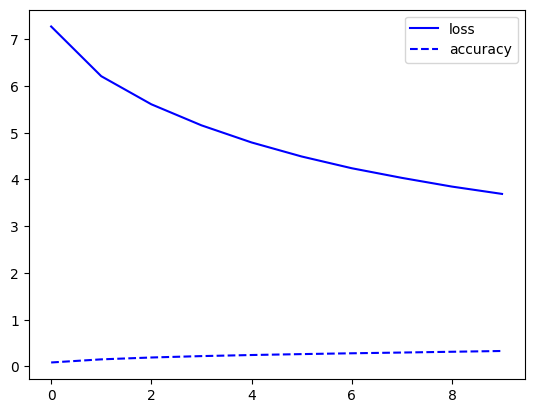

In [26]:
history = model.history
plt.plot(history.history['loss'],
         'b-', label='loss')
plt.plot(history.history['accuracy'],
         'b--', label='accuracy')

plt.legend()
plt.show()

### Generating new Text based on Seed Input

In [27]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''

    # Final Output
    output_text = []

    # Intial Seed Sequence
    input_text = seed_text

    # Create num_gen_words
    for i in range(num_gen_words):

        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]

        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')

        # Predict Class Probabilities for each word
        pred_word_ind = model.predict(pad_encoded, verbose=0)[0]

        # Grab word
        pred_word = tokenizer.index_word[np.argmax(pred_word_ind)]

        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word

        output_text.append(pred_word)
        if num_gen_words == 1:
            best_3_w = np.argsort(pred_word_ind)[-1:-4:-1]
            return best_3_w, pred_word_ind[best_3_w], pred_word_ind


    # Make it look like a sentence.
    return ' '.join(output_text)

In [28]:
def generate_text_2(model, tokenizer, seq_len, seed_text, num_gen_words):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''
    
    # Final Output
    output_text = []

    # Intial Seed Sequence
    input_text = seed_text
    
    # Little Beam-search-like
    beam_search = []
    
    # Create num_gen_words
    for i in range(num_gen_words):

        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]

        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')

        # Predict Class Probabilities for each word
        pred_word_ind = model.predict(pad_encoded, verbose=0)[0]
        
        # Testing out grab best 3 words
        
        best_3_w = np.argsort(pred_word_ind)[-1:-4:-1]
        beam_search.append(best_3_w)
        tokens_array = []
        tokens_prob_array = []
        for i in best_3_w:
            # Grab word
            pred_word = tokenizer.index_word[i]
            
            # Update the sequence of input text (shifting one over with the new word)
            try_text = input_text + ' ' + pred_word
            tokens, token_prop, _ = generate_text(model=model, tokenizer=tokenizer, seq_len=seq_len, seed_text=try_text, num_gen_words=1)
            tokens_array.append(tokens)
            tokens_prob_array.append(token_prop * pred_word_ind[i])
        id_token = np.argmax(np.array(tokens_prob_array).reshape(9,))
        ind_1st_word = id_token.__floordiv__(3)

        ind_2nd_word = id_token - (3 * ind_1st_word)
        counter = 0
        while best_3_w[ind_1st_word] == tokens_array[ind_1st_word][ind_2nd_word]:
            ind_1st_word = np.random.randint(0,3)
            counter += 1
            if counter > 4:
                ind_2nd_word = np.random.randint(0,3)
        first_word = tokenizer.index_word[best_3_w[ind_1st_word]]
        second_word = tokenizer.index_word[tokens_array[ind_1st_word][ind_2nd_word]]
        
        input_text += ' ' + first_word #+ " " + second_word

        output_text.append(first_word)
        # output_text.append(second_word)

    # Make it look like a sentence.
    return ' '.join(output_text)

In [29]:

#random.seed(112)
ramdom_pick = random.randint(0,len(text_sequences))
random_seed_text = text_sequences[ramdom_pick]
seed_text = ' '.join(random_seed_text)
seed_text

"gruppe in einem sachlichen Zusammenhang ste- hen oder = durch die Kenntnisse , Erfahrungen und Fertig- keiten gewonnen worden sind , welche für di weitere dienstliche Verwendung von Nutzen oder Interesse sind , ' : Da förderliche Zeiten der angestrebten Verwendung im öffentlichen Dienst nicht gleichwertig sind ( gleichwertige Zeiten sind"

In [30]:
generate_text_2(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=50)

'auch in den fällen des bundes oder des bundes zu erfassen . ( ( ( . ( . ( . . . . ( ( ( ( ( . ( ( . . ( ( . . . ( ( ( ( . . ( . . . . ('

In [31]:
generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=25)

'die voraussetzungen des $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $'

In [32]:
generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=1)

(array([ 3,  1, 50]),
 array([0.06599554, 0.05759018, 0.05666592], dtype=float32),
 array([4.4420689e-10, 5.7590175e-02, 1.5502315e-02, ..., 3.3011792e-17,
        6.4396360e-20, 4.7454757e-12], dtype=float32))

In [33]:
_, __, array = generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=1)

import pandas as pd
df = pd.DataFrame(array)
df.describe()

,0
count,1.872970e+05
mean,5.339116e-06
std,3.288187e-04
min,1.486649e-37
25%,2.430519e-17
50%,7.245422e-15
75%,1.594704e-12
max,6.599554e-02
